In [1]:
#Importing necessary libraries
import zipfile
import cv2
import random
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from os import listdir
from collections import Counter
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


## Part 1 - Visualizing the Face Images

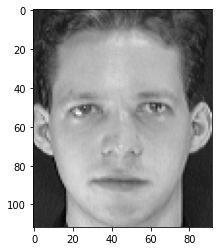

In [2]:
with open ('/content/drive/MyDrive/DataMining/assignmentThree/s1/1.pgm', 'rb') as image:
  img = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

In [3]:
faces = {}
with zipfile.ZipFile("/content/drive/MyDrive/DataMining/assignmentThree.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

1. Visualizing randomly selected 16 faces in a 4x4 grid.

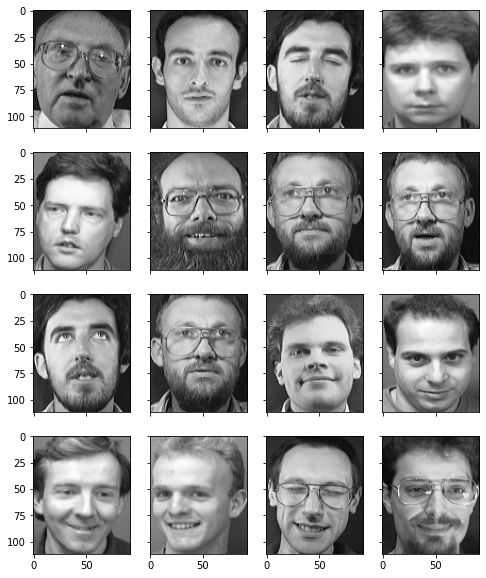

In [4]:
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(random.sample(list(faces.values()), 16)) 
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

2. Report the face image size, number of images and number of classes.

In [5]:
faceshape = list(faces.values())[0].shape
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Face image size:", faceshape)
print("Number of images:", len(faces))
print("Number of classes:", len(classes))

Face image size: (112, 92)
Number of images: 400
Number of classes: 40


## Part 2 - Train Test Split

In [6]:
train_matrix = []
train_label = []

test_matrix = []
test_label = []
for key,val in faces.items():
    if key.endswith("/10.pgm"):
        test_matrix.append(val.flatten())
        test_label.append(key.split("/")[0]) 
    else: 
      train_matrix.append(val.flatten())
      train_label.append(key.split("/")[0])

In [7]:
train_matrix = np.array(train_matrix)
test_matrix = np.array(test_matrix)

In [8]:
print(f'Number of images in the train set: {len(train_matrix)}')
print(train_matrix.shape)

Number of images in the train set: 360
(360, 10304)


In [9]:
print(f'Number of images in the test set: {len(test_matrix)}')
print(test_matrix.shape)

Number of images in the test set: 40
(40, 10304)


## Part 3 - Apply PCA to get Eigenfaces

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20, svd_solver="randomized", whiten=True)
pca.fit(train_matrix)

PCA(n_components=20, svd_solver='randomized', whiten=True)

In [11]:
eigenfaces = pca.components_.reshape(20, 112 * 92)

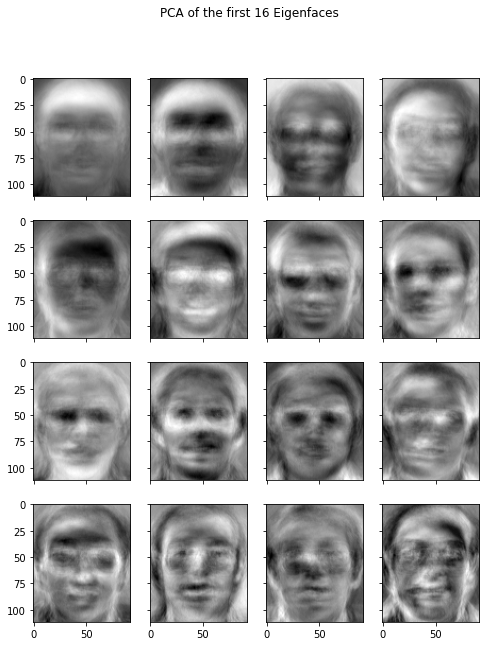

In [12]:
# Show the first 16 eigenfaces
fig, axes = plt.subplots(nrows = 4,ncols = 4, sharex=True, sharey=True, figsize=(8,10))
fig.suptitle('PCA of the first 16 Eigenfaces')
for ax, i in zip(axes.flatten(), eigenfaces[:16]):
    ax.imshow(i.reshape(112,92), axes = ax, cmap="gray")
plt.show()

## Part 4 - Face Recognition

In [13]:
print(eigenfaces.shape)

(20, 10304)


In [14]:
train_sample_weights = np.matmul(eigenfaces, (train_matrix - pca.mean_).T)

In [15]:
train_matrix = np.array(train_matrix)

In [16]:
print(train_sample_weights.shape)

(20, 360)


In [17]:
test_matrix = np.array(test_matrix)

In [18]:
test_sample_weights = []
for i in range(test_matrix.shape[0]):
  test_weights = np.matmul(eigenfaces, (test_matrix[i] - pca.mean_).T )
  test_sample_weights.append(test_weights)

In [19]:
test_sample_weights = np.array(test_sample_weights)

In [20]:
print(test_sample_weights.shape)

(40, 20)


In [21]:
matches = []
for i in range(len(test_matrix)):
  dist = []
  for j in range(train_matrix.shape[0]): 
   e_dist = np.linalg.norm(train_sample_weights[:,j] - test_sample_weights[i]) 
   dist.append(e_dist)
  match = np.argmin(dist)
  matches.append((i,match))
print(matches)

[(0, 7), (1, 282), (2, 18), (3, 35), (4, 40), (5, 50), (6, 55), (7, 64), (8, 78), (9, 86), (10, 90), (11, 106), (12, 108), (13, 124), (14, 127), (15, 135), (16, 152), (17, 155), (18, 169), (19, 171), (20, 182), (21, 191), (22, 206), (23, 207), (24, 219), (25, 230), (26, 235), (27, 251), (28, 256), (29, 266), (30, 278), (31, 283), (32, 293), (33, 301), (34, 309), (35, 310), (36, 327), (37, 337), (38, 344), (39, 355)]


In [22]:
for i in matches: 
  test_img = test_matrix[i[0]] 
  train_img = train_matrix[i[1]]
  fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2)
  fig.suptitle('Test Image ' + str([i[0]]) + ' vs Train Image ' + str([i[1]]))
  ax1.imshow(test_img.reshape(112,92), cmap='gray')
  ax2.imshow(train_img.reshape(112,92), cmap='gray')

Output hidden; open in https://colab.research.google.com to view.

In [23]:
print('Eigenfaces shape', eigenfaces.shape)
print('Train Sample Weights shape', train_sample_weights.shape)
print('Test Sample Weights shape', test_sample_weights.shape)

Eigenfaces shape (20, 10304)
Train Sample Weights shape (20, 360)
Test Sample Weights shape (40, 20)


In [24]:
scores = []
for i in range(len(test_sample_weights)):
  score_img = []
  for j in range(train_sample_weights[0].shape[0]):
    e_dist = np.linalg.norm(train_sample_weights[:, j] - test_sample_weights[i])
    score_img.append( (e_dist, i, j) )
    
  score_img = sorted(score_img, key = lambda t: t[0])
  scores.append(score_img[0])

In [25]:
left_pointer, right_pointer = 0, 9
correct_matches = 0
for i in scores:
  if i[2] in range(left_pointer, right_pointer):
    correct_matches += 1
  left_pointer += 9
  right_pointer += 9
  
accuracy = (correct_matches / len(scores)) * 100
print(accuracy)

95.0


In [26]:
print(sum(pca.explained_variance_ratio_))

0.7026564114675334


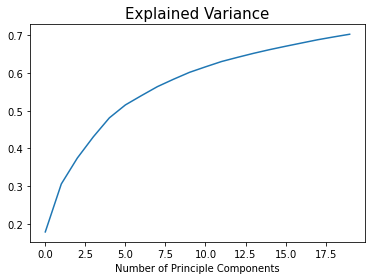

In [27]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Explained Variance',fontsize=15)
plt.xlabel('Number of Principle Components', fontsize=10)
plt.show()

## Part - 5

In [28]:
pca = PCA(n_components=2, svd_solver="randomized", whiten=True)
pca.fit(train_matrix)

PCA(n_components=2, svd_solver='randomized', whiten=True)

In [29]:
eigenfaces = pca.components_.reshape(2, 112 * 92)
print(len(eigenfaces))

2


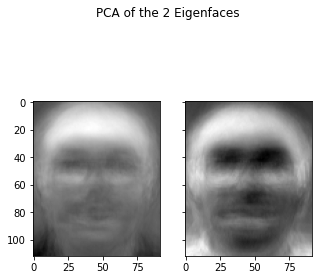

In [30]:
fig, axes = plt.subplots(nrows = 1,ncols = 2, sharex=True, sharey=True, figsize=(5,5))
fig.suptitle('PCA of the 2 Eigenfaces')
for ax, i in zip(axes.flatten(), eigenfaces):
    ax.imshow(i.reshape(112,92), axes = ax, cmap="gray")
plt.show()

In [31]:
train_sample_weights = np.matmul(eigenfaces, (train_matrix - pca.mean_).T)

In [32]:
train_matrix = np.array(train_matrix)

In [33]:
print(train_sample_weights.shape)

(2, 360)


In [34]:
test_matrix = np.array(test_matrix)

In [35]:
test_sample_weights = []
for i in range(test_matrix.shape[0]):
  test_weights = np.matmul(eigenfaces, (test_matrix[i] - pca.mean_).T )
  test_sample_weights.append(test_weights)

In [36]:
test_sample_weights = np.array(test_sample_weights)

In [37]:
print(test_sample_weights.shape)

(40, 2)


In [38]:
matches = []
for i in range(len(test_matrix)):
  dist = []
  for j in range(train_matrix.shape[0]): 
   e_dist = np.linalg.norm(train_sample_weights[:,j] - test_sample_weights[i]) 
   dist.append(e_dist)
  match = np.argmin(dist)
  matches.append((i,match))
print(matches)

[(0, 5), (1, 337), (2, 23), (3, 35), (4, 40), (5, 53), (6, 58), (7, 199), (8, 80), (9, 89), (10, 182), (11, 157), (12, 108), (13, 120), (14, 127), (15, 79), (16, 152), (17, 306), (18, 169), (19, 181), (20, 91), (21, 295), (22, 350), (23, 207), (24, 218), (25, 166), (26, 235), (27, 251), (28, 159), (29, 231), (30, 278), (31, 283), (32, 292), (33, 337), (34, 76), (35, 320), (36, 328), (37, 204), (38, 344), (39, 339)]


In [39]:
for i in matches: 
  test_img = test_matrix[i[0]] 
  train_img = train_matrix[i[1]]
  fig, (ax1, ax2) = plt.subplots(nrows = 1,ncols = 2)
  fig.suptitle('Test Image ' + str([i[0]]) + ' vs Train Image ' + str([i[1]]))
  ax1.imshow(test_img.reshape(112,92), cmap='gray')
  ax2.imshow(train_img.reshape(112,92), cmap='gray')

Output hidden; open in https://colab.research.google.com to view.

In [40]:
print('Eigenfaces shape', eigenfaces.shape)
print('Train Sample Weights shape', train_sample_weights.shape)
print('Test Sample Weights shape', test_sample_weights.shape)

Eigenfaces shape (2, 10304)
Train Sample Weights shape (2, 360)
Test Sample Weights shape (40, 2)


In [41]:
scores = []
for i in range(len(test_sample_weights)):
  score_img = []
  for j in range(train_sample_weights[0].shape[0]):
    e_dist = np.linalg.norm(train_sample_weights[:, j] - test_sample_weights[i])
    score_img.append( (e_dist, i, j) )
    
  score_img = sorted(score_img, key = lambda t: t[0])
  scores.append(score_img[0])

In [42]:
left_pointer, right_pointer = 0, 9
correct_matches = 0
for i in scores:
  if i[2] in range(left_pointer, right_pointer):
    correct_matches += 1
  
  left_pointer += 9
  right_pointer += 9
  
accuracy = (correct_matches / len(scores)) * 100
print(accuracy)

57.49999999999999


In [43]:
print(sum(pca.explained_variance_ratio_))

0.3058112331450039


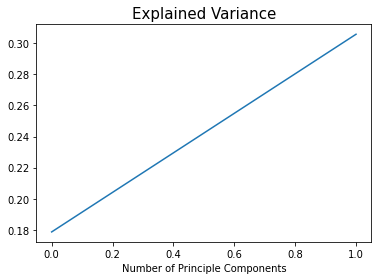

In [44]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.title('Explained Variance',fontsize=15)
plt.xlabel('Number of Principle Components', fontsize=10)
plt.show()

When comparing the results using explained variance ratio of PCA considering the number of components as 20, we notice that the explained variance ratio amounts to approximately 70.26% whereas the explained variance ratio when the number of components is 2 amounts to 30.58% 

A key reason for this staggering change is the number of components taken into account. Explained variance is a statistical measure of how much variation in a dataset can be attributed to each of the principal components (eigenvectors) generated by PCA. In very basic terms, it refers to the amount of variability in a data set that can be attributed to each individual principal component. In other words, it tells us how much of the total variance is “explained” by each component.

Hence, since the number of components in the second case is 2, the total variance explained by those components will also be relatively lesser when compared to the first case where the number of components is 20. 

## Converting to PDF

In [45]:
!sudo apt update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [913 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

In [46]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa
Suggested packages:
  fonts-noto apache2 | lighttpd | httpd poppler-utils ghostscript
  fonts-japanese-mi

In [47]:
!jupyter nbconvert --to pdf '/content/drive/MyDrive/DataMining/DataMiningAssignmentThree.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/DataMining/DataMiningAssignmentThree.ipynb to pdf
[NbConvertApp] Support files will be in DataMiningAssignmentThree_files/
[NbConvertApp] Making directory ./DataMiningAssignmentThree_files
[NbConvertApp] Making directory ./DataMiningAssignmentThree_files
[NbConvertApp] Making directory ./DataMiningAssignmentThree_files
[NbConvertApp] Making directory ./DataMiningAssignmentThree_files
[NbConvertApp] Making directory ./DataMiningAssignmentThree_files
[NbConvertApp] Making directory ./DataMiningAssignmentThree_files
[NbConvertApp] Writing 79297 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 483872 bytes to /content/drive/MyDrive/DataMin